In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import matplotlib.pyplot as plt

In [29]:
# objective: create a neural net that approximates the ocean current vector field

input_size = 2
layer_1 = 100
layer_2 = 200
layer_3 = 400
layer_4 = 200
layer_5 = 100
output_size = 2
learning_rate = 0.01

class CurrentNet(nn.Module):
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(1.0)
    
    def __init__(self):
        super(CurrentNet, self).__init__()
        self.fc1 = nn.Linear(input_size, layer_1)
        self.fc2 = nn.Linear(layer_1, layer_2)
        self.fc3 = nn.Linear(layer_2, layer_3)
        self.fc4 = nn.Linear(layer_3, layer_4)
        self.fc5 = nn.Linear(layer_4, layer_5)
        self.fc6 = nn.Linear(layer_5, output_size)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=.0)
        x = F.leaky_relu(self.fc2(x), negative_slope=.0)
        x = F.leaky_relu(self.fc3(x), negative_slope=.0)
        x = F.leaky_relu(self.fc4(x), negative_slope=.0)
        x = F.leaky_relu(self.fc5(x), negative_slope=.0)
        x = F.leaky_relu(self.fc6(x), negative_slope=.0)
        return x

model = CurrentNet()

loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [30]:
# data formatting

with open('..\\data\\oscar_current_data_U.json', 'r') as datafile:
    u = json.load(datafile)[0]

with open('..\\data\\oscar_current_data_V.json', 'r') as datafile:
    v = json.load(datafile)[0]

print(u['header'])
print(v['header'])

u_data = u['data']
v_data = v['data']

print(len(u_data))
print(len(v_data))

X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

'''
. = train example
x = test example

. . . . .
. x . x .
. . . . .
. x . x .
. . . . .

'''

for i in range(len(u_data)):
    c = i % 1080
    r = int(i / 1080)
    if (u_data[i] == None or v_data[i] == None):
        continue
    if (r % 2 == 0 and c % 2 == 0):
        X_test_list.append([float(r) / 481.0, float(c) / 1080.0])
        y_test_list.append([u_data[i], v_data[i]])
    else:
        X_train_list.append([float(r) / 481.0, float(c) / 1080.0])
        y_train_list.append([u_data[i], v_data[i]])

X_train = torch.tensor(X_train_list)
y_train = torch.tensor(y_train_list)
X_test = torch.tensor(X_test_list)
y_test = torch.tensor(y_test_list)

print(X_train.size())
print(y_train.size())
print(X_test.size())
print(y_test.size())

{'discipline': 10, 'disciplineName': 'Oceanographic_products', 'center': -3, 'centerName': 'Earth & Space Research', 'refTime': '2014-01-31T00:00:00.000Z', 'significanceOfRT': 0, 'significanceOfRTName': 'Analysis', 'parameterCategory': 1, 'parameterCategoryName': 'Currents', 'parameterNumber': 2, 'parameterNumberName': 'U_component_of_current', 'parameterUnit': 'm.s-1', 'forecastTime': 0, 'surface1Type': 160, 'surface1TypeName': 'Depth below sea level', 'surface1Value': 15, 'numberPoints': 519480, 'shape': 0, 'shapeName': 'Earth spherical with radius = 6,367,470 m', 'scanMode': 0, 'nx': 1080, 'ny': 481, 'lo1': 20, 'la1': 80, 'lo2': 379.6666666666667, 'la2': -80, 'dx': 0.3333333333333333, 'dy': 0.3333333333333333}
{'discipline': 10, 'disciplineName': 'Oceanographic_products', 'center': -3, 'centerName': 'Earth & Space Research', 'refTime': '2014-01-31T00:00:00.000Z', 'significanceOfRT': 0, 'significanceOfRTName': 'Analysis', 'parameterCategory': 1, 'parameterCategoryName': 'Currents', '

In [31]:
# model training

num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model_y = model(X_train)
    loss = loss_function(model_y, y_train)
    train_losses.append(loss.item())

    model_test_y = model(X_test)
    test_loss = loss_function(model_test_y, y_test)
    test_losses.append(test_loss.item())
    
    loss.backward()
    optimizer.step()

    print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


tensor([[-0., -0.],
        [-0., -0.],
        [-0., -0.],
        ...,
        [-0., -0.],
        [-0., -0.],
        [-0., -0.]], grad_fn=<LeakyReluBackward0>)


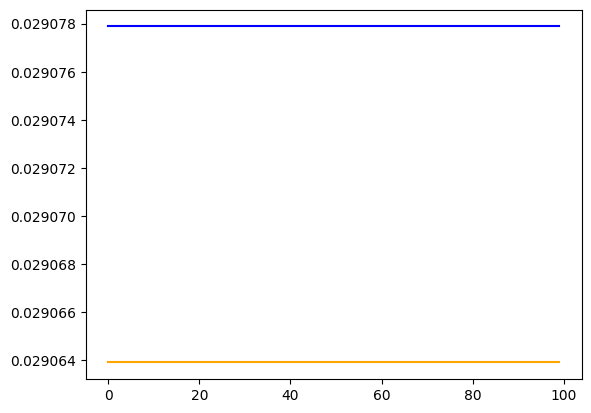

In [32]:
fig, ax = plt.subplots(1)
ax.plot(train_losses, c='b')
ax.plot(test_losses, c='orange')

print(model(X_train))